In [15]:
import os
import sys

libs_dir = os.path.join("/".join(os.getcwd().split("/")[:-2]))
sys.path.append(libs_dir)

import numpy as np
import matplotlib.pyplot as plt
from libs.figure_config import *
import matplotlib.patches as patches
from libs.satellite import *

In [16]:
satellite_1293 = LEOsatellite(
    libs_dir + '/data/STARLINK_1293.txt')
location_aizu = np.loadtxt(
    libs_dir + '/data/ogs_loc.txt')
location_sendai = np.loadtxt(
    libs_dir + '/data/ogs_loc_sendai.txt')
year = 2021
day = 357
hour = 16
minute = 29

t = np.arange(0, 241, 10) 
second = 56 + t 
utc = 9

latitude_bob = location_aizu[:, 0]
longitude_bob = location_aizu[:, 1]
elevation_bob = location_aizu[:, 2]

latitude_alice = location_sendai[:, 0]
longitude_alice = location_sendai[:, 1]
elevation_alice = location_sendai[:, 2]

# Bob用のリスト
# Location: Sendai
slant_path_bob_lst = np.zeros(len(second))
zenith_angle_bob_lst = np.zeros(len(second))

# Alice用のリスト
# Location: Aizuwakamatsu
slant_path_alice_lst = np.zeros(len(second))
zenith_angle_alice_lst = np.zeros(len(second))

for idx in range(len(second)):
    # slant_path_lst[idx], zenith_angle_lst[idx] = satellite_1293.computeGeometricWithUser(
    #     year, day, hour, minute, second[idx], utc,
    #     longitude[idx], latitude[idx], elevation[idx]
    slant_path_bob_lst[idx], zenith_angle_bob_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_bob[0], latitude_bob[0], elevation_bob[0] # bobが単一の場合、[0]でアクセス
    )

    slant_path_alice_lst[idx], zenith_angle_alice_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_alice[0], latitude_alice[0], elevation_alice[0]
    )

slant_path_bob_lst = slant_path_bob_lst * 1000
slant_path_alice_lst = slant_path_alice_lst * 1000

In [17]:
qber_simul = np.load('results/qber_siml_bbm92_test1_n_s05.npy')
# skr_simul = np.load('results/skr_simul_bbm92_test2.npy')

qber_analysis = np.load('results/qber_analysis_bbm92_test1_n_s05.npy')
# skr_analysis = np.load('results/skr_analysis_bbm92_test1.npy')

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

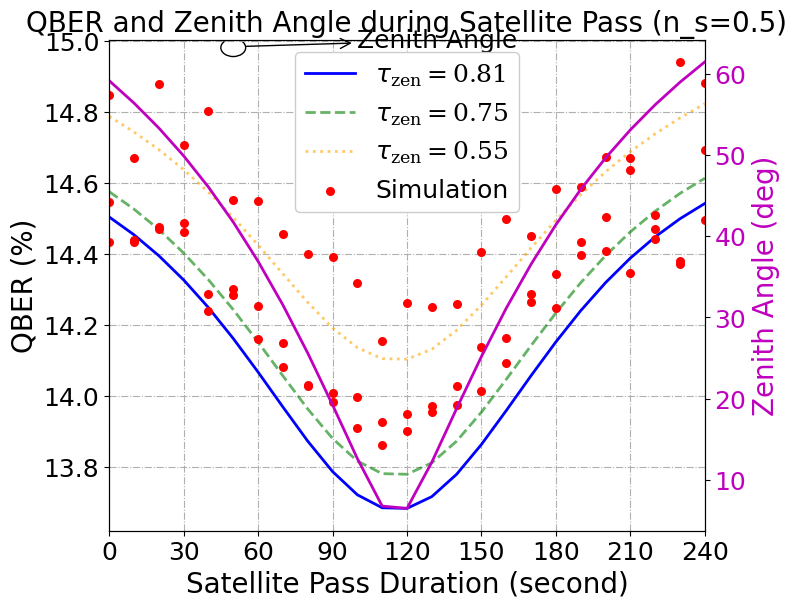

In [18]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(t, qber_analysis[0][:]*100, label=r'$\tau_{\rm zen} = 0.81$', color='blue')
ax1.plot(t, qber_analysis[1][:]*100, ls='--', label=r'$\tau_{\rm zen} = 0.75$', color='green', alpha=0.6)
ax1.plot(t, qber_analysis[2][:]*100, ls=':', label=r'$\tau_{\rm zen} = 0.55$', color='orange', alpha=0.6)


ax1.scatter(t, qber_simul[0][:]*100, marker='o', c='red', s=30, linewidths=1, zorder=2, label='Simulation')
ax1.scatter(t, qber_simul[1][:]*100, marker='o', c='red', s=30, linewidths=1, zorder=2)
ax1.scatter(t, qber_simul[2][:]*100, marker='o', c='red', s=30, linewidths=1, zorder=2)
# print(len(t))  # x 軸の長さ
# print(len(qber_simul))  # y 軸の長さ

# ax1.scatter(t, [q * 100 for q in qber_simul], 
#             marker='o', c='red', s=30, linewidths=1, zorder=2, label='Simulation')# ax1.scatter(t, qber_simul[1][:]*100, marker='o', c='red', s=30, linewidths=1, zorder=2)
# ax1.scatter(t, qber_simul[2][:]*100, marker='o', c='red', s=30, linewidths=1, zorder=2)


ax1.set_xlabel(r'Satellite Pass Duration (second)')
ax1.set_ylabel(r"QBER (%)")

ax1.set_xlim(0, 240)

ellipse = patches.Ellipse((50, 14.98), width=10, height=0.05, edgecolor='black', facecolor='none', lw=1)
ax1.add_patch(ellipse)
arrow_target_x = 50 + (12 / 2) * np.cos(np.pi / 4)  # 半径方向に
arrow_target_y = 14.98 + (0.01 / 2) * np.sin(np.pi / 4)


# 矢印とラベルの追加
ax1.annotate(
    r'Zenith Angle',
    xy=(arrow_target_x, arrow_target_y),
    xytext=(100, arrow_target_y-0.003),  # ラベル位置
    arrowprops=dict(arrowstyle='<-', color='black', lw=1),
    fontsize=18,
    color='black'
)

ax2 = ax1.twinx()
ax2.plot(t, zenith_angle_bob_lst, color='m', linewidth=2)
ax2.set_ylabel(r"Zenith Angle (deg)", color='m')
ax2.tick_params(axis='y', labelcolor='m')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, 
    labels1 + labels2, 
    loc='upper center',
    fontsize=18)

ax1.grid()
plt.tight_layout()
_ = plt.xticks(np.arange(0, 241, 30))
plt.title('QBER and Zenith Angle during Satellite Pass (n_s=0.5)', fontsize=20)
plt.savefig('figure_results/qber_sat_pass_yudai_test1_n_s1_new_081.pdf', format='pdf', bbox_inches="tight")

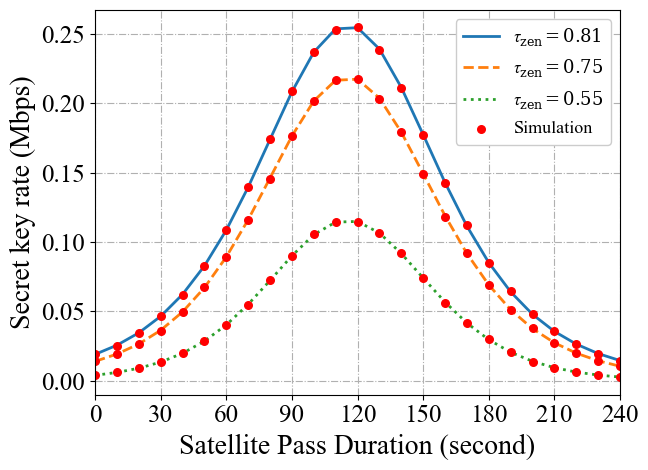

In [ ]:
plt.plot(t, skr_analysis[0][:]/10**6, label=r'$\tau_{\rm zen} = 0.81$')
plt.plot(t, skr_analysis[1][:]/10**6, ls='--', label=r'$\tau_{\rm zen} = 0.75$')
plt.plot(t, skr_analysis[2][:]/10**6, ls=':', label=r'$\tau_{\rm zen} = 0.55$')

plt.scatter(t, skr_simul[0][:]/10**6, marker='o', c='red', s=30, linewidths=1, zorder=2, label='Simulation')
plt.scatter(t, skr_simul[1][:]/10**6, marker='o', c='red', s=30, linewidths=1, zorder=2)
plt.scatter(t, skr_simul[2][:]/10**6, marker='o', c='red', s=30, linewidths=1, zorder=2)

plt.xlabel(r'Satellite Pass Duration (second)')
plt.ylabel(r"Secret key rate (Mbps)")

plt.xlim(0, 240)

plt.legend()

plt.grid()
plt.tight_layout()
_ = plt.xticks(np.arange(0, 241, 30))
plt.savefig(f'figure_results/skr_sat_pass_yudai_test2.pdf', format='pdf', bbox_inches="tight")